# Data Challenge GENERALI

# Préliminaires

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pickle #Pour sauvegarder les modèles
from urllib.request import urlopen #Pour charger les modèles depuis GitHub

Pour charger et sauvegarder des modèles :

In [0]:
load_models_url = "https://raw.githubusercontent.com/BenjaminBcmp/DataChallengeGenerali/master/modeles/" #GitHub
#load_models_url = "/Users/Benjamin/Documents/MATHAPPLI/APST-ML/DataChallenge/DataChallengeGenerali/modeles/" #Benjamin
#save_models_path = "/Users/Benjamin/Documents/MATHAPPLI/APST-ML/DataChallenge/DataChallengeGenerali/modeles/" #Benjamin
save_models_path="C:/Users/Asus/Documents/Cours/EI2/APST/Generali/Modele/" #Célia
#save_models_path = "" #VM Google Cloud

In [102]:
import multiprocessing
n_jobs=multiprocessing.cpu_count()
n_jobs

4

# Sommaire


1. [Traitement des données](#data)  
2. [Réduction de dimension](#reduction_dim)
3. [Préparatifs pour l'entrainement de modèles](#preparatifs)
4. [XGBoost](#xgb)
5. [RandomForest](#rfc)
6. [LightGBM](#lgbm)
7. [Régression logistique](#reglog)
8. [Réseau de neurones](#neural_net)
9. [Adaboost](#ada)
10. [SVM](#svm)
11. [Ensembling](#ensembling)
12. [Construction des prédictions](#pred)

# Traitement des données
<a id="data"></a>

## Importation

In [103]:
X_train_url = "https://raw.githubusercontent.com/BenjaminBcmp/DataChallengeGenerali/master/data/X_train_new_data.csv"
X_test_url = "https://raw.githubusercontent.com/BenjaminBcmp/DataChallengeGenerali/master/data/X_test_new_data.csv"
y_train_url = "https://raw.githubusercontent.com/BenjaminBcmp/DataChallengeGenerali/master/data/y_train_saegPGl_new_data.csv"
X_train = pd.read_csv(X_train_url, header=0, index_col=0)
X_test = pd.read_csv(X_test_url, header=0, index_col=0)
y_train = pd.read_csv(y_train_url, header=0, index_col=0)
print(X_train.shape)
print(X_test.shape)

(10110, 34)
(3412, 34)


In [104]:
X_train.head()

,Identifiant,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,...,Insee,pluie,catnat,criminalite,pprn,chomage,rev_med,log_sociaux,fuites,entreprises
0,18702,2014,1,0,V,N,1,O,1,O,...,65440,7,1.0,0.044062,1,11.350,17098.000000,556,7.589677,4756.0
1,3877,2014,1,0,V,V,V,V,V,V,...,14341,1,0.0,0.039299,0,9.750,19767.619048,826,2.636626,12025.0
2,4942,2013,1,1,V,V,V,V,V,V,...,75109,0,0.0,0.109341,0,8.275,32166.978261,1054,15.665170,100837.0
3,13428,2013,"0,246575342",0,N,V,V,V,V,V,...,92004,0,0.0,0.063562,0,7.750,23320.555556,1240,4.064081,31493.0
4,17137,2015,1,0,V,N,2,O,1,O,...,59340,1,0.0,0.062406,67,12.950,20914.000000,1025,6.069644,38651.0


In [105]:
X_train["ft_22_categ"].describe()

count    10110.000000
mean      1725.529674
std        643.949264
min         -1.000000
25%       1950.000000
50%       1960.000000
75%       1980.000000
max       2016.000000
Name: ft_22_categ, dtype: float64

In [106]:
X_train.get_dtype_counts()


float64     9
int64       8
object     17
dtype: int64

In [107]:
y_train.head()

,Identifiant,target
0,18702,0
1,3877,1
2,4942,0
3,13428,0
4,17137,0


## Encoding des variables catégorielles

One-hot-encoding des variables catégorielles pour que notre jeu de données soit utilisable par les algorithmes. Pour s'assurer d'avoir les mêmes variables dans le train et le test, on regroupe les deux datasets ensemble, on encode les variables catégorielles puis on les sépare à nouveau.

In [0]:
id_train = X_train['Identifiant'] #Pour séparer le train du test
id_test = X_test['Identifiant']

In [110]:
X_train_test = pd.concat([X_train,X_test])
X_train_test.shape

(13522, 34)

La variable 'EXPO' est numérique mais les flottants sont entrés comme des chaines de caractère, avec une virgule au lieu d'un point pour la partie décimale. On applique donc une fonction sur toute la colonne afin d'avoir une variable numérique :

In [0]:
func = lambda x: float(x.replace(',','.')) if type(x) is str else x
X_train_test['EXPO'] = X_train_test['EXPO'].apply(func)

On change le type des variables catégorielles du train et du test :

In [112]:
vars_categ = [var for var in X_train.columns if var[:2]=="ft"]
#vars_categ = [var for var in X_train.columns if var[:2]=="ft" and var!="ft_22_categ"]
X_train_test[vars_categ] = X_train_test[vars_categ].astype('category')
X_train_test.dtypes

Identifiant       int64
ft_2_categ     category
EXPO            float64
ft_4_categ     category
ft_5_categ     category
ft_6_categ     category
ft_7_categ     category
ft_8_categ     category
ft_9_categ     category
ft_10_categ    category
ft_11_categ    category
ft_12_categ    category
ft_13_categ    category
ft_14_categ    category
ft_15_categ    category
ft_16_categ    category
ft_17_categ    category
ft_18_categ    category
ft_19_categ    category
superficief     float64
ft_21_categ    category
ft_22_categ    category
ft_23_categ    category
ft_24_categ    category
Insee            object
pluie             int64
catnat          float64
criminalite     float64
pprn              int64
chomage         float64
rev_med         float64
log_sociaux     float64
fuites          float64
entreprises     float64
dtype: object

Problème de type pour ft_23_categ :

In [113]:
X_train_test.ft_23_categ.cat.categories

Index([0.0, 0.3, 0.6, 1.0, 1.5, 2.0, '0.0', '0.3', '0.6', '1.0', '1.5', '2.0',
       'V'],
      dtype='object')

In [114]:
func = lambda x: float(x.replace(',','.')) if type(x) is str and x != 'V' else x
X_train_test['ft_23_categ'] = X_train_test['ft_23_categ'].apply(func)
X_train_test['ft_23_categ'] = X_train_test['ft_23_categ'].astype('category')
X_train_test.ft_23_categ.cat.categories

Index([0.0, 0.3, 0.6, 1.0, 1.5, 2.0, 'V'], dtype='object')

ft_22_categ possède beaucoup de niveaux qui sont des années, nous allons donc les regrouper par groupe de 50 ans afin de réduire le nombre de variables après one-hot-encoding : 

In [115]:
X_train_test.ft_22_categ.cat.categories

Float64Index([  -1.0, 1500.0, 1545.0, 1550.0, 1600.0, 1613.0, 1630.0, 1700.0,
              1718.0, 1750.0,
              ...
              2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0,
              2015.0, 2016.0],
             dtype='float64', length=149)

In [0]:
def regroup_year(col):
    """On remplace chaque année par la cinquantaine inférieure
    Exemple : on remplace 1973 par 1950, 2012 par 2000"""
    for k in range(len(col)):
        if col[k] != -1: #-1 : la valeur n'est pas renseignée
            if col[k] % 100 >= 50:
                col[k] = col[k]//100 * 100 + 50
            else:
                col[k] = col[k]//100 * 100
    return col

X_train_test.ft_22_categ = regroup_year(np.array(X_train_test.ft_22_categ))
X_train_test.ft_22_categ = X_train_test.ft_22_categ.astype('category')

In [117]:
X_train_test.ft_22_categ.cat.categories

Float64Index([  -1.0, 1500.0, 1550.0, 1600.0, 1700.0, 1750.0, 1800.0, 1850.0,
              1900.0, 1950.0, 2000.0],
             dtype='float64')

Une autre solution est de considérer ft_22_categ comme ordinal et permettra de réduire le nombre de variables crées par le One-hot-encoding : 

In [0]:
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()

In [0]:
#X_train_test['ft_22_categ']=le.fit_transform(X_train_test['ft_22_categ'])

One-hot-encoding :

In [0]:
X_train_test = pd.get_dummies(X_train_test, columns=vars_categ, prefix=vars_categ)

In [121]:
print(X_train_test.columns)

Index(['Identifiant', 'EXPO', 'superficief', 'Insee', 'pluie', 'catnat',
       'criminalite', 'pprn', 'chomage', 'rev_med', 'log_sociaux', 'fuites',
       'entreprises', 'ft_2_categ_2012', 'ft_2_categ_2013', 'ft_2_categ_2014',
       'ft_2_categ_2015', 'ft_2_categ_2016', 'ft_4_categ_0', 'ft_4_categ_1',
       'ft_5_categ_N', 'ft_5_categ_O', 'ft_5_categ_V', 'ft_6_categ_N',
       'ft_6_categ_O', 'ft_6_categ_V', 'ft_7_categ_1', 'ft_7_categ_2',
       'ft_7_categ_3', 'ft_7_categ_V', 'ft_8_categ_N', 'ft_8_categ_O',
       'ft_8_categ_V', 'ft_9_categ_1', 'ft_9_categ_2', 'ft_9_categ_3',
       'ft_9_categ_V', 'ft_10_categ_N', 'ft_10_categ_O', 'ft_10_categ_V',
       'ft_11_categ_N', 'ft_11_categ_O', 'ft_11_categ_V', 'ft_12_categ_N',
       'ft_12_categ_O', 'ft_12_categ_V', 'ft_13_categ_N', 'ft_13_categ_O',
       'ft_13_categ_V', 'ft_14_categ_N', 'ft_14_categ_O', 'ft_14_categ_V',
       'ft_15_categ_AUTRE', 'ft_15_categ_V', 'ft_16_categ_IDENTIQUE',
       'ft_16_categ_V', 'ft_17_categ_N', 

On re-sépare en train et test :

In [0]:
X_train = X_train_test.loc[X_train_test['Identifiant'].isin(id_train),:].copy()
X_test = X_train_test.loc[X_train_test['Identifiant'].isin(id_test),:].copy()

In [123]:
X_test.shape

(3412, 99)

In [124]:
X_train.shape

(10110, 99)

## Suppression de colonnes

On supprime les colonnes "Identifiant" et "Insee" (inutile pour nos modèles) :

In [0]:
X_train.drop('Identifiant',1, inplace=True)
X_test.drop('Identifiant',1, inplace=True)
y_train.drop('Identifiant',1, inplace=True)

X_train.drop('Insee', 1, inplace=True)
X_test.drop('Insee', 1, inplace=True)

Suppression de certaines colonnes pour faire marcher d'anciens modèles :

In [0]:
X_train.drop('fuites', 1, inplace=True)
X_test.drop('fuites', 1, inplace=True)

X_train.drop('entreprises', 1, inplace=True)
X_test.drop('entreprises', 1, inplace=True)

On modifie y_train pour qu'il soit de la forme (n_samples, ) :

In [127]:
y_train = np.array(y_train).ravel()
y_train.shape

(10110,)

Colonnes finales présentes dans notre jeu de données :

In [29]:
X_train.columns

Index(['EXPO', 'superficief', 'pluie', 'catnat', 'criminalite', 'pprn',
       'chomage', 'rev_med', 'log_sociaux', 'ft_2_categ_2012',
       'ft_2_categ_2013', 'ft_2_categ_2014', 'ft_2_categ_2015',
       'ft_2_categ_2016', 'ft_4_categ_0', 'ft_4_categ_1', 'ft_5_categ_N',
       'ft_5_categ_O', 'ft_5_categ_V', 'ft_6_categ_N', 'ft_6_categ_O',
       'ft_6_categ_V', 'ft_7_categ_1', 'ft_7_categ_2', 'ft_7_categ_3',
       'ft_7_categ_V', 'ft_8_categ_N', 'ft_8_categ_O', 'ft_8_categ_V',
       'ft_9_categ_1', 'ft_9_categ_2', 'ft_9_categ_3', 'ft_9_categ_V',
       'ft_10_categ_N', 'ft_10_categ_O', 'ft_10_categ_V', 'ft_11_categ_N',
       'ft_11_categ_O', 'ft_11_categ_V', 'ft_12_categ_N', 'ft_12_categ_O',
       'ft_12_categ_V', 'ft_13_categ_N', 'ft_13_categ_O', 'ft_13_categ_V',
       'ft_14_categ_N', 'ft_14_categ_O', 'ft_14_categ_V', 'ft_15_categ_AUTRE',
       'ft_15_categ_V', 'ft_16_categ_IDENTIQUE', 'ft_16_categ_V',
       'ft_17_categ_N', 'ft_17_categ_O', 'ft_17_categ_V', 'ft_18_categ_V'

# Réduction de dimension
<a id="reduction_dim"></a>

## PCA

Afin de réduire la dimension du problème, on recherche les axes avec une plus grande variante grâce à PCA sur les variables quantitatives:

In [0]:
from sklearn.decomposition import PCA

In [0]:
var_quant = [var for var in X_train.columns if var[:2]!="ft"]

PCA=PCA(n_components=9)
PCA.fit(X_train[var_quant])


PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

On perd le côté explicatif du modèle mais la représentation ci-dessous permet de voir quelle variable est importante sur chaque axe.

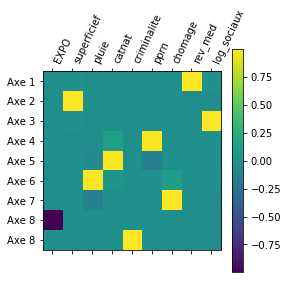

In [0]:
plt.matshow(PCA.components_,cmap='viridis')
plt.yticks([0,1,2,3,4,5,6,7,8],['Axe 1','Axe 2','Axe 3','Axe 4','Axe 5','Axe 6','Axe 7','Axe 8','Axe 8'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(X_train[var_quant].columns)),X_train[var_quant].columns,rotation=65,ha='left')
plt.show()

On cherche les axes avec la plus grande variance :

In [0]:
X_pca=PCA.transform(X_train[var_quant]) 
print (PCA.explained_variance_ratio_)

[7.86232130e-01 2.11400091e-01 2.35017192e-03 8.84267370e-06
 7.85405290e-06 7.99279023e-07 1.08835011e-07 2.21967815e-09
 1.14394999e-11]


Les résultats ci-dessus permettent d'extraire les trois axes principaux.

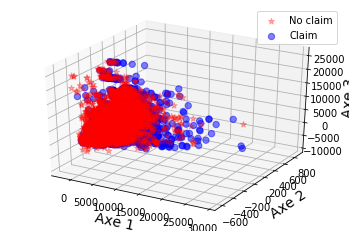

In [0]:
from mpl_toolkits.mplot3d import Axes3D
labels=['No claim','Claim']
cdict={'No claim':'red','Claim':'blue'}
labl={'No claim':0,'Claim':1}
marker={'No claim':'*','Claim':'o'}
alpha={'No claim':.3, 'Claim':.5}
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for l in labels:
  ix=np.where(y_train==labl[l])
  ax.scatter3D(xs=X_pca[:,1][ix],ys=X_pca[:,2][ix],zs=X_pca[:,0][ix],c=cdict[l],s=40,label=l,marker=marker[l],alpha=alpha[l])

ax.set_xlabel('Axe 1',fontsize=14)
ax.set_ylabel('Axe 2',fontsize=14)
ax.set_zlabel('Axe 3',fontsize=14)
plt.legend()
plt.show()

In [0]:
var_cat = [var for var in X_train.columns if var[:2]=="ft"]
X_train=pd.concat([pd.DataFrame({0:X_pca[:,0]}),pd.DataFrame({1:X_pca[:,1]}),X_train[var_cat]],axis=1)

In [0]:
X_train.head()

,0,1,ft_2_categ_2012,ft_2_categ_2013,ft_2_categ_2014,ft_2_categ_2015,ft_2_categ_2016,ft_4_categ_0,ft_4_categ_1,ft_5_categ_N,...,ft_24_categ_ 1,ft_24_categ_ 2,ft_24_categ_ 3,ft_24_categ_ 4,ft_24_categ_ 5,ft_24_categ_ 6,ft_24_categ_ 7,ft_24_categ_ 8,ft_24_categ_ 9,ft_24_categ_>=10
0,-3698.225577,-401.428736,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,-1013.815883,170.658243,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11379.739758,-388.612765,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2520.055472,-1334.497853,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,119.536483,-772.866697,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


## Factor analysis of mixed data (FAMD)

Afin de réduire la dimension de l'ensemble du modèle, on peut utiliser FAMD (voir [ici](https://github.com/MaxHalford/prince#factor-analysis-of-mixed-data-famd))

In [0]:
vars_categ = [var for var in X_train.columns if var[:2]=="ft"]
X_train[vars_categ] = X_train[vars_categ].astype('category')

In [0]:
import prince
famd = prince.FAMD(n_components=50)
famd = famd.fit(X_train)

In [0]:
X_famd=famd.transform(X_train) 

Critère de Kaiser : on retient les axes où les valeurs propres sont supérieures à l'inertie moyenne

In [0]:
inertie_moyenne=famd.total_inertia_/len(famd.eigenvalues_)
np.where(np.array(famd.eigenvalues_)>=inertie_moyenne)[0]

(27,)

In [0]:
sum(famd.explained_inertia_[:2])


0.990841664015883

Les deux premiers axes représentent 75% de l'inertie totale.

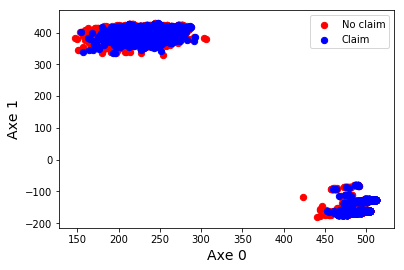

In [0]:
from mpl_toolkits.mplot3d import Axes3D
labels=['No claim','Claim']
cdict={'No claim':'red','Claim':'blue'}
labl={'No claim':0,'Claim':1}
marker={'No claim':'*','Claim':'o'}
alpha={'No claim':.3, 'Claim':.5}


for l in labels:
  ix=y_train==labl[l]
  plt.scatter(x=X_famd[0][ix],y=X_famd[1][ix],c=cdict[l],s=40,label=l)

plt.xlabel('Axe 0',fontsize=14)
plt.ylabel('Axe 1',fontsize=14)
plt.legend()
plt.show()

Le critère du coude consiste à retire les axes   : les deux premiers axes avant que la décroissance devienne régulière (ici : axe 0 et axe 1). On retrouve le même résultat qu'avec la première régle.

Text(0.5, 0, 'Axe')

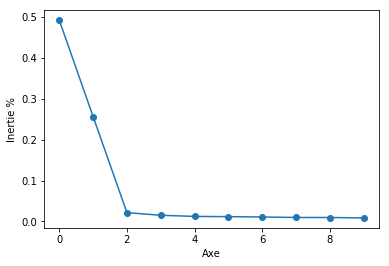

In [0]:
plt.plot(range(0,len(famd.explained_inertia_))[:10],famd.explained_inertia_[:10],'-o')
plt.ylabel('Inertie %')
plt.xlabel('Axe')

In [0]:
X_train=X_famd

# Préparatifs pour l'entrainement de modèles
<a id="preparatifs"></a>

Pour pouvoir tester les performances de nos modèles, on découpe le jeu de données train en train-test :

In [30]:
from sklearn.model_selection import train_test_split

seed = 666
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X_train,y_train,train_size=0.7,test_size=0.3, random_state=seed)
Xtrain = X_train
Ytrain = y_train
Xtrain.head()

,EXPO,superficief,pluie,catnat,criminalite,pprn,chomage,rev_med,log_sociaux,ft_2_categ_2012,...,ft_24_categ_ 1,ft_24_categ_ 2,ft_24_categ_ 3,ft_24_categ_ 4,ft_24_categ_ 5,ft_24_categ_ 6,ft_24_categ_ 7,ft_24_categ_ 8,ft_24_categ_ 9,ft_24_categ_>=10
0,1.000000,1351.0,7,1.0,0.044062,1,11.350,17098.000000,556.0,0,...,0,1,0,0,0,0,0,0,0,0
1,1.000000,1972.0,1,0.0,0.039299,0,9.750,19767.619048,826.0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.000000,1630.0,0,0.0,0.109341,0,8.275,32166.978261,1054.0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.246575,532.0,0,0.0,0.063562,0,7.750,23320.555556,1240.0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.000000,1050.0,1,0.0,0.062406,67,12.950,20914.000000,1025.0,0,...,0,0,0,1,0,0,0,0,0,0


On définit la métrique utilisée par le challenge ainsi qu'un scorer basé sur cette métrique, qui sera utilisé dans la GridSearch pour déterminer le meilleur modèle :

In [0]:
import numpy as np

def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

In [0]:
from sklearn.metrics import make_scorer
gini_scorer = make_scorer(gini_normalized, greater_is_better=True, needs_proba=True)

On définit une fonction pour afficher l'importance des variables dans nos modèles :

In [0]:
def feat_importance(model, feature_names, max_num_features=10):
    """model doit posséder la méthode feature_importances_
    num_features : nombre de features à afficher"""
    importance = list(zip(feature_names, model.feature_importances_))
    importance.sort(key=lambda x: x[1], reverse=True)
    importance = [[elem[0], elem[1]] for elem in importance]
    names, vals = zip(*importance)
    plt.figure()
    plt.barh(np.arange(max_num_features)[::-1], vals[:max_num_features], tick_label=names[:max_num_features])
    plt.xticks([])
    plt.show()

# XGBoost
<a id="xgb"></a>

In [0]:
from xgboost import XGBClassifier, Booster
from xgboost import plot_importance

## (Optionnel) Chargement d'un modèle

Pour éviter de faire un GridSearch :

In [0]:
model_name = "xgbfull"
with urlopen(load_models_url+'XGB/%s.txt'%(model_name)) as f:
    XGB = pickle.loads(f.read())

In [35]:
XGB.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.7,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 3,
 'missing': nan,
 'n_estimators': 1000,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 1,
 'reg_lambda': 0,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

## Tuning par GridSearch

On entraîne un classifieur XGBoost par GridSearch (comme pour le benchmark) sur notre jeu de données. On commence par fixer `n_estimators` et `learning_rate` pour déterminer les autres paramètres :

In [0]:
#Grille de paramètres
max_depth = [1, 2, 3, 4, 5]
min_child_weight = [1, 2, 3, 4, 5]
reg_alpha = [0,1]
reg_lambda = [0,1]
subsample = [0.3, 0.7, 1]
colsample_bytree = [0.3, 0.7, 1]
colsample_bylevel = [0.3, 0.7, 1]
param_grid = dict(max_depth=max_depth, min_child_weight=min_child_weight, reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                 colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bytree, subsample=subsample)

#GridSearch
grid_search = GridSearchCV(XGBClassifier(learning_rate=0.1, n_estimators=100),
                           param_grid, cv=5, n_jobs=n_jobs, scoring=gini_scorer, verbose=3)
grid_result = grid_search.fit(X_train, y_train)

#Résultats
best_params = grid_result.best_params_
print("Best parameters :", best_params)

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   13.9s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   31.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:   57.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done 2032 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:  6.3min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=8)]: Done 3856 tasks      | elapsed: 10.4min
[Parallel(n_jobs=8)]: Done 4592 tasks      | elapsed: 13.4min
[Parallel(n_jobs=8)]: Done 5392 tasks      | elapsed: 15.4min
[Parallel(n_jobs=8)]: Done 6256 tasks      | elapsed: 18.3min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed: 22.2min


Best parameters : {'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'max_depth': 3, 'min_child_weight': 4, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1}


In [0]:
max_depth = best_params["max_depth"]
min_child_weight = best_params["min_child_weight"]
reg_alpha = best_params["reg_alpha"]
reg_lambda = best_params["reg_lambda"]
subsample = best_params["subsample"]
colsample_bytree = best_params["colsample_bytree"]
colsample_bylevel = best_params["colsample_bylevel"]

On cherche maintenant les meilleurs valeurs pour `n_estimators` et `learning_rate` :

In [0]:
#Grille de paramètres
learning_rate = [1e-3, 1e-2, 1e-1]
n_estimators = [200, 500, 700, 1000, 2000]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

#GridSearch
grid_search = GridSearchCV(XGBClassifier(max_depth=max_depth, min_child_weight=min_child_weight, reg_alpha=reg_alpha,
                                         reg_lambda=reg_lambda, colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel),
                           param_grid, cv=5, n_jobs=n_jobs, scoring=gini_scorer, verbose=3)
grid_result = grid_search.fit(Xtrain, Ytrain)

#Résultats
best_params = grid_result.best_params_
print("Best parameters :", best_params)
XGB = grid_result.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   33.6s
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed:  3.2min finished


Best parameters : {'learning_rate': 0.01, 'n_estimators': 1000}


## Résultats

Score obtenu :

In [0]:
print(grid_result.best_score_)

In [0]:
gini_scorer(XGB, Xtest, Ytest)

0.5526017333709308

In [0]:
gini_normalized(Ytest, XGB.predict_proba(Xtest)[:,1])

0.5526017333709308

Importance des variables :

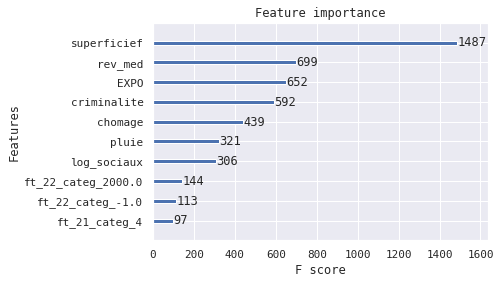

In [0]:
plot_importance(XGB, max_num_features=10)
plt.show()

Sauvegarde du modèle :

In [0]:
model_name = 'xgb' + str(seed)
with open(save_models_path+'%s.txt'%(model_name), 'wb') as f:
    pickle.dump(XGB, f)

# Random Forest
<a id="rfc"></a>

In [0]:
from sklearn.ensemble import RandomForestClassifier

## Chargement d'un modèle

In [0]:
model_name = "rfcfull"
with urlopen(load_models_url+'RFC/%s.txt'%(model_name)) as f:
    RFC = pickle.loads(f.read())

In [0]:
RFC.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 30,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 0.01,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Tuning par GridSearch

In [0]:
#Grille de paramètres
max_depth = [None, 3, 5, 7, 10, 15]
min_samples_split = [0.001, 0.005, 0.01, 0.05]
max_features = [10, 20, 30, 40, 50, 60, 70]
param_grid = dict(max_features=max_features, min_samples_split=min_samples_split, max_depth=max_depth)

#GridSearch
grid_search = GridSearchCV(RandomForestClassifier(n_estimators=30),
                           param_grid, cv=5, n_jobs=n_jobs, scoring=gini_scorer, verbose=3)
grid_result = grid_search.fit(Xtrain, Ytrain)

#Résultats
best_params = grid_result.best_params_
print("Best parameters :", best_params)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


ValueError: ignored

On optimise `n_estimators` :

In [0]:
max_features = best_params["max_features"]
min_samples_split = best_params["min_samples_split"]
max_depth = best_params["max_depth"]

In [0]:
#Grille de paramètres
n_estimators = [30, 50, 100, 300, 500, 700, 1000, 1500, 2000, 2500, 3000]
param_grid = dict(n_estimators=n_estimators)

#GridSearch
grid_search = GridSearchCV(RandomForestClassifier(max_features=max_features, min_samples_split=min_samples_split, max_depth=max_depth),
                           param_grid, cv=10, n_jobs=n_jobs, scoring=gini_scorer, verbose=5)
grid_result = grid_search.fit(Xtrain, Ytrain)

#Résultats
best_params = grid_result.best_params_
print("Best parameters :", best_params)
RFC = grid_result.best_estimator_

Score :

In [0]:
print(grid_result.best_score_)

0.4340533318488004


In [0]:
print(gini_scorer(RFC, Xtest, Ytest))

0.4588538684084016


In [0]:
print(gini_normalized(Ytest, RFC.predict_proba(Xtest)[:,1]))

0.4588538684084016


Importance des variables :

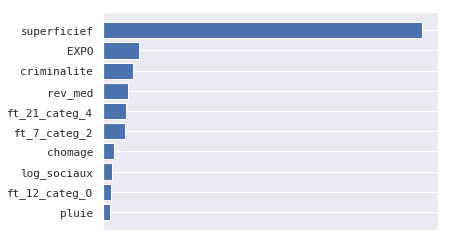

In [0]:
feat_importance(RFC, np.array(X_train.columns), 10)

Sauvegarde du modèle :

In [0]:
model_name = 'rfc' + str(seed)
with open(save_models_path+'%s.txt'%(model_name), 'wb') as f:
    pickle.dump(RFC, f)

## (Pour les tests) Paramètres customs

In [0]:
RFC = RandomForestClassifier(n_estimators=200, max_features=10, max_depth=50, min_samples_split=500)
RFC.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
print(gini_scorer(RFC, Xtest, Ytest))

-0.4084453997648442


In [0]:
gini_normalized(Ytest, RFC.predict_proba(Xtest)[:,1])

0.40845458553791886

# Light GBM
<a id="lgbm"></a>

On utilise la version avec l'API de scikit-learn (voir [ici](https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.LGBMClassifier))

In [0]:
from lightgbm import LGBMClassifier

Premier test sans spécifier de paramètres :

In [0]:
LGBM = LGBMClassifier()
LGBM.fit(Xtrain, Ytrain)
gini_scorer(LGBM, Xtest, Ytest)

0.7879568106312294

## Chargement d'un modèle

In [0]:
model_name = "lgbmfull"
with urlopen(load_models_url+'LGBM/%s.txt'%(model_name)) as f:
    LGBM = pickle.loads(f.read())

In [41]:
LGBM.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_samples': 10,
 'min_child_weight': 0.01,
 'min_split_gain': 0,
 'n_estimators': 1500,
 'n_jobs': -1,
 'num_leaves': 10,
 'objective': None,
 'random_state': None,
 'reg_alpha': 1,
 'reg_lambda': 0.1,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

## Tuning par GridSearch

On commence en fixant `n_estimators` et `learning_rate`, qu'on optimisera après :

In [0]:
#Grille de paramètres
num_leaves = [2, 4, 5, 7, 10, 20]
max_depth = [2, 3, 5, -1]
subsample_for_bin = [200000]
min_split_gain = [0]
min_child_weight = [1e-2, 1e-1, 1, 10, 50, 100]
min_child_samples = [10, 20, 30, 50, 70, 100]
reg_alpha = [0, 1, 10]
reg_lambda = [0, 1e-1]

#GridSearch
param_grid = dict(num_leaves=num_leaves, max_depth=max_depth, subsample_for_bin=subsample_for_bin, min_split_gain=min_split_gain, 
                  min_child_weight=min_child_weight, min_child_samples=min_child_samples,reg_alpha=reg_alpha, reg_lambda=reg_lambda)
grid_search = GridSearchCV(LGBMClassifier(learning_rate=0.1, n_estimators=100),
                           param_grid, cv=5, n_jobs=n_jobs, scoring=gini_scorer, verbose=3)
grid_result = grid_search.fit(X_train, y_train)


#Résultats
best_params = grid_result.best_params_
print("Best parameters :", best_params)

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   15.6s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:   27.7s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   43.0s
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 2032 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 3856 tasks      | elapsed:  3.5min
[Parallel(n_jobs=8)]: Done 4592 tasks      | elapsed:  4.1min
[Parallel(n_jobs=8)]: Done 5392 tasks      | elapsed:  4.8min
[Parallel(n_jobs=8)]: Done 6256 tasks      | elapsed:  5.6min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed:  6.5min


Best parameters : {'max_depth': 3, 'min_child_samples': 50, 'min_child_weight': 0.01, 'min_split_gain': 0, 'num_leaves': 7, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample_for_bin': 200000}


In [0]:
print(grid_result.best_score_)

0.4395635472916551


In [0]:
num_leaves = best_params["num_leaves"]
max_depth = best_params["max_depth"]
subsample_for_bin = best_params["subsample_for_bin"]
min_split_gain = best_params["min_split_gain"]
min_child_weight = best_params["min_child_weight"]
min_child_samples = best_params["min_child_samples"]
reg_alpha = best_params["reg_alpha"]
reg_lambda = best_params["reg_lambda"]

Optimisation de `n_estimators` et `learning_rate` :

In [0]:
#Grille de paramètres
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
n_estimators = [30, 50, 70, 100, 500, 1000, 1500, 2000]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

#GridSearch
grid_search = GridSearchCV(LGBMClassifier(num_leaves=num_leaves, max_depth=max_depth, subsample_for_bin=subsample_for_bin, 
                                          min_split_gain=min_split_gain, min_child_weight=min_child_weight, 
                                          min_child_samples=min_child_samples,reg_alpha=reg_alpha, reg_lambda=reg_lambda),
                           param_grid, cv=10, n_jobs=n_jobs, scoring=gini_scorer, verbose=3)
grid_result = grid_search.fit(Xtrain, Ytrain)

#Résultats
best_params = grid_result.best_params_
print("Best parameters :", best_params)
LGBM = grid_result.best_estimator_

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   26.7s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 640 out of 640 | elapsed:  3.3min finished


Best parameters : {'learning_rate': 0.1, 'n_estimators': 100}


Score :

In [0]:
print(grid_result.best_score_)

0.44303067416355846


In [78]:
gini_scorer(LGBM, Xtest, Ytest)

0.5489558536992708

In [0]:
gini_normalized(Ytest, LGBM.predict_proba(Xtest)[:,1])

0.42980526904200966

Importance des variables : 

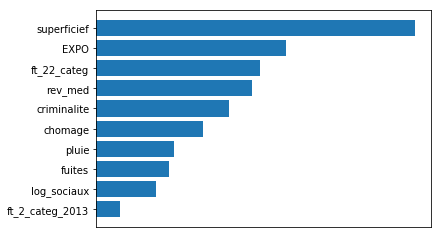

In [0]:
feat_importance(LGBM, np.array(X_train.columns), 10)

On remarque que RandomForest et Light GBM n'ont pas les mêmes variables d'importance.

Sauvegarde du modèle :

In [0]:
model_name = 'lgbmfull_fuites_label_encoder'# + str(seed)
with open(save_models_path+'%s.txt'%(model_name), 'wb') as f:
    pickle.dump(LGBM, f)

# Régression logistique
<a id="reglog"></a>

In [0]:
from sklearn.linear_model import LogisticRegression

## Chargement d'un modèle

In [0]:
model_name = "logregfull"
with urlopen(load_models_url+'LogReg/%s.txt'%(model_name)) as f:
    LogReg = pickle.loads(f.read())

## Tuning par GridSearch

On ajuste ici un modèle avec pénalisation l2. Comme il y a peu de paramètres à choisir, on fait de la valisation croisée 10 folds :

In [0]:
#Grille de paramètres
tol = [1e-4, 1e-6, 1e-8, 1e-10, 1e-12]
C = [1e-3, 1e-2, 1e-1, 1, 10]

#GridSearch
param_grid = dict(tol=tol, C=C)
grid_search = GridSearchCV(LogisticRegression(),
                           param_grid, cv=10, n_jobs=n_jobs, scoring=gini_scorer, verbose=3)
grid_result = grid_search.fit(Xtrain, Ytrain)


#Résultats
best_params = grid_result.best_params_
print("Best parameters :", best_params)
LogReg = grid_result.best_estimator_

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   15.7s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:  1.3min finished
/home/Asus/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best parameters : {'C': 10, 'tol': 1e-08}


Score :

In [0]:
print(grid_result.best_score_)

0.2529610866781718


In [77]:
gini_scorer(LogReg, Xtest, Ytest)

0.4395815843678673

Sauvegarde du modèle :

In [0]:
model_name = 'logreg' + str(seed)
with open(save_models_path+'%s.txt'%(model_name), 'wb') as f:
    pickle.dump(LogReg, f)

# Réseau de neurones
<a id="neural_net"></a>

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout

Modèle :

In [0]:
Ytrain_neural = to_categorical(Ytrain)
Ytest_neural = to_categorical(Ytest)

In [0]:
N = Xtrain.shape[1] #Dimension en entrée
H = 400 #Dimension de la couche cachée
K = 2 #Nombre de classes

In [0]:
#Modèle
model = Sequential()
model.add(Dense(H, input_dim=N))
model.add(Activation("tanh"))
model.add(Dense(H))
model.add(Activation("tanh"))
model.add(Dense(H))
model.add(Activation("tanh"))
model.add(Dense(H))
model.add(Activation("tanh"))
model.add(Dense(H))
model.add(Activation("tanh"))
model.add(Dense(H//4))
model.add(Activation("tanh"))
model.add(Dense(H//4))
model.add(Activation("tanh"))
model.add(Dense(H//4))
model.add(Activation("tanh"))
model.add(Dense(10))
model.add(Activation("tanh"))
model.add(Dense(10))
model.add(Activation("tanh"))
model.add(Dense(K))
model.add(Activation("tanh"))
model.add(Dense(K))
model.add(Activation("tanh"))
model.add(Dense(K))
model.add(Activation("sigmoid"))

#Optimiseur
sgd = SGD(lr=0.1, momentum=0)
adam = Adam(lr=0.0003)

#Compilation
model.compile(optimizer=adam,loss='binary_crossentropy', metrics=['accuracy'])

Entrainement :

In [0]:
history = model.fit(Xtrain, Ytrain_neural, epochs=500, batch_size=300, verbose=False)

Score : 

In [0]:
model.evaluate(Xtest, Ytest_neural)

3033/3033 [==============================] - 1s 206us/step


[0.49058501029855694, 0.7876689748484192]

In [0]:
gini_normalized(Ytest, model.predict_proba(Xtest)[:,1])

0.3689950367410886

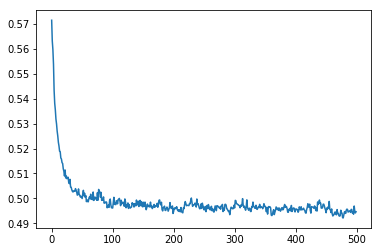

In [0]:
plt.plot(history.history['loss'])

# Adaboost
<a id="ada"></a>

In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [0]:
#Grille de paramètres
n_estimators=[50]
learning_rate=[0.01]
algorithm=['SAMME.R']
base_estimator=[LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=5,
        min_child_samples=70, min_child_weight=0.01, min_split_gain=0,
        n_estimators=70, n_jobs=-1, num_leaves=10, objective=None,
        random_state=None, reg_alpha=0, reg_lambda=0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)]
#GridSearch
param_grid = dict(n_estimators=n_estimators,learning_rate=learning_rate,algorithm=algorithm,base_estimator=base_estimator)
grid_search = GridSearchCV(AdaBoostClassifier(),
                           param_grid, cv=5, n_jobs=n_jobs, scoring=gini_scorer, verbose=3)
grid_result = grid_search.fit(X_train, y_train)


#Résultats
best_params = grid_result.best_params_
print("Best parameters :", best_params)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 16.0min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 37.3min
[Parallel(n_jobs=4)]: Done 315 out of 315 | elapsed: 40.3min finished


Best parameters : {'algorithm': 'SAMME.R', 'base_estimator': LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=5,
        min_child_samples=70, min_child_weight=0.01, min_split_gain=0,
        n_estimators=70, n_jobs=-1, num_leaves=10, objective=None,
        random_state=None, reg_alpha=0, reg_lambda=0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0), 'learning_rate': 0.01, 'n_estimators': 50}


In [0]:
print(grid_result.best_score_)

0.4351455770194289


In [0]:
ADA=AdaBoostClassifier(algorithm='SAMME.R',base_estimator=XGBClassifier(colsample_by_level=0.7, colsample_by_tree=1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, reg_alpha=1, reg_lambda=0), learning_rate=0.01, n_estimators=50)
ADA.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_by_level=0.7,
       colsample_by_tree=1, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1, reg_lambda=0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          learning_rate=0.01, n_estimators=50, random_state=None)

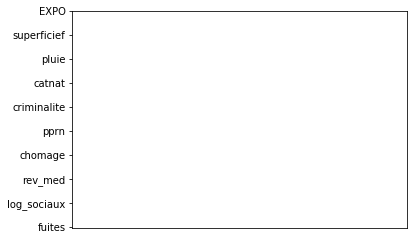

In [0]:
feat_importance(ADA, np.array(X_train.columns), 10)

# SVM
<a id="svm"></a>

In [0]:
from sklearn.svm import SVC

## GridSearch

In [0]:
#Grille de paramètres
kernel = ['linear', 'poly', 'rbf']
C = [1e-12, 1e-6, 1e-4]
gamma = ['scale']

#GridSearch
param_grid = dict(kernel=kernel, C=C, gamma=gamma)
grid_search = GridSearchCV(SVC(probability=True),
                           param_grid, cv=5, n_jobs=n_jobs, scoring=gini_scorer, verbose=5)
grid_result = grid_search.fit(X_train, y_train)


#Résultats
best_params = grid_result.best_params_
print("Best parameters :", best_params)
SVM = grid_result.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  2.1min


## Score

In [0]:
print(grid_result.best_score_)

In [0]:
print(gini_scorer(SVM, Xtest, Ytest))

# Ensembling
<a id="ensembling"></a>

Dans cette partie on s'intéresse à l'ensembling, une méthode qui consiste à utiliser les prédictions de plusieurs estimateurs différents afin d'en créer un nouveau plus performant. Nous nous concentrons sur deux méthodes différentes :
* Weighted Average Probabilities (voir [ici](https://scikit-learn.org/stable/modules/ensemble.html#weighted-average-probabilities-soft-voting)) : consiste à attribuer un poids à chaque modèle, puis à calculer la moyenne pondérée des probabilités d'appartenance à chaque classe.
* Stacking/Blending (voir [ici](https://mlwave.com/kaggle-ensembling-guide/)) : consiste à créer un nouveau jeu de données à partir des prédictions faites par nos modèles. On entraine ensuite un nouveau modèle sur ce jeu de données.

In [0]:
ensemble_list = [XGB, RFC, LGBM, LogReg]
ensemble_names = ['XGB', 'RFC', 'LGBM', 'LogReg']

In [0]:
print("Scores individuels sur le test :")
for k in range(len(ensemble_list)):
    print(ensemble_names[k], ':', gini_scorer(ensemble_list[k], Xtest, Ytest))

## Weighted Average Probabilities


Prédictions de la classe 1 par les algorithmes :

In [0]:
def raw_preds1(ensemble, X):
    """Prédictions des modèles de premier niveau"""
    y_pred = np.hstack([model.predict_proba(X) for model in ensemble]) #Toutes les prédictions
    return y_pred[:, 1::2] #Prédictions pour la classe 1

def ensemble_preds(raw_preds, weights):
    """Prédiction de l'ensemble sur Xtest"""
    if sum(weights) ==0:
        return np.zeros((len(Xtest), 2))
    else:
        return np.average(raw_preds, axis=1, weights=weights)

def normalize(weights):
	# calculate l1 vector norm
	result = np.linalg.norm(weights, 1)
	# check for a vector of all zeros
	if result == 0.0:
		return weights
	# return normalized vector (unit norm)
	return weights / result

### GridSearch

On cherche les poids sur une grille définie comme un produit cartésien (voir [ici](https://machinelearningmastery.com/weighted-average-ensemble-for-deep-learning-neural-networks/)). Pour chaque combinaison de poids, on évalue le score de notre ensemble par validation croisée 5-folds. Pour cela, on commence par créer `preds`, une liste prédictions que chaque modèle ensembliste effectue sur les 5 folds de X_train

In [0]:
from itertools import product
from sklearn.model_selection import KFold

def score_ensemble(raw_preds, weights, X, y, kf):
    """Renvoie le score de l'ensemble avec les poids weights, calculé par
    validation croisée k-folds sur X"""
    scores = []
    for k,(train_index, test_index) in enumerate(kf.split(X)):
        y_test = y[test_index]
        preds = ensemble_preds(raw_preds[k], weights)
        scores.append(gini_normalized(y_test, preds))
    return np.mean(scores)

# grid search weights
def grid_search(X, Y):
    """X : données sur lesquels on applique les algos de 1er niveau.
    Y : targets"""
	# define weights to consider
    w = np.arange(0, 1.05, 0.05)
    best_score, best_weights = 0.0, None
    #fit a model for every fold
    raw_preds = []
    kf = KFold(n_splits=5, shuffle=False)
    for train_index, test_index in kf.split(X):
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        ytrain, ytest = Y[train_index], Y[test_index]
        ensemble = [XGBClassifier(**XGB.get_params()).fit(Xtrain, ytrain),
                    RandomForestClassifier(**RFC.get_params()).fit(Xtrain, ytrain),
                    LGBMClassifier(**LGBM.get_params()).fit(Xtrain, ytrain),
                    LogisticRegression(**LogReg.get_params()).fit(Xtrain, ytrain)]
        raw_preds.append(raw_preds1(ensemble, Xtest))
	# iterate all possible combinations (cartesian product)
    for weights in product(w, repeat=len(ensemble)):
		# skip if all weights are equal
        if len(set(weights)) == 1:
            continue
        # hack, normalize weight vector
        weights = normalize(weights)
        # evaluate weights
        score = score_ensemble(raw_preds, weights, X, Y, kf)
        if score > best_score:
            best_score, best_weights = score, weights
            print('>%s %.3f' % (best_weights, best_score))
    return list(best_weights)

In [129]:
best_weights_grid = grid_search(X_train, y_train)
print("\nBest weights :", best_weights_grid)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

>[0. 0. 0. 1.] 0.425
>[0. 0. 1. 0.] 0.441
>[0.  0.  0.5 0.5] 0.445
>[0.         0.         0.66666667 0.33333333] 0.445
>[0.  0.  0.6 0.4] 0.445
>[0.         0.         0.71428571 0.28571429] 0.446
>[0.    0.    0.625 0.375] 0.446
>[0.         0.         0.63636364 0.36363636] 0.446
>[0.         0.         0.61538462 0.38461538] 0.446
>[0.         0.         0.63157895 0.36842105] 0.446
>[0.   0.25 0.5  0.25] 0.446
>[0.         0.22222222 0.55555556 0.22222222] 0.446
>[0.         0.18181818 0.54545455 0.27272727] 0.446
>[0.         0.17391304 0.56521739 0.26086957] 0.446
>[0.         0.18518519 0.55555556 0.25925926] 0.446

Best weights : [0.0, 0.18518518518518517, 0.5555555555555555, 0.25925925925925924]
Score : 0.5512688488871716


### Optimisation d'une fonction de perte (1ère méthode)

In [0]:
from scipy import optimize

On cherche les poids en maximisant la fonction de score grâce à l'algorithme Simple (voir [ici](https://www.kaggle.com/daisukelab/optimizing-ensemble-weights-using-simple)). On commence par définir la fonction à minimiser, qui utilise les valeurs prédites sur l'ensemble de validation (Xtest) :

In [0]:
raw_preds = np.array([model.predict_proba(Xtest) for model in ensemble_list]) #Prédictions de chaque modèle

def ensemble_preds(weights):
    """Prédiction de l'ensemble sur Xtest"""
    if sum(weights) ==0:
        return np.zeros((len(Xtest), 2))
    else:
        return np.average(raw_preds, axis=0, weights=weights)

def loss_function(weights):
    """Renvoie la valeur de la perte pour les prédictions de l'ensemble.
    Ici la perte est l'opposée de la fonction de score, soit -gini_normalized"""
    return -gini_normalized(Ytest, ensemble_preds(weights)[:,1])

def acc_function(weights):
    return -loss_function(weights)

On optimise maintenant la fonction de perte sous contraintes (l'algorithme est copié de GitHub dans la cellule suivante) :

In [0]:
# Copie de l'algorithme Simple
# Source : https://github.com/chrisstroemel/Simple/blob/master/Simple.py

from heapq import heappush, heappop, heappushpop
import numpy
import math
import time
import matplotlib.pyplot as plotter

CAPACITY_INCREMENT = 1000


class _Simplex:
	def __init__(self, pointIndices, testCoords, contentFractions, objectiveScore, opportunityCost, contentFraction, difference):
		self.pointIndices = pointIndices
		self.testCoords = testCoords
		self.contentFractions = contentFractions
		self.contentFraction = contentFraction
		self.__objectiveScore = objectiveScore
		self.__opportunityCost = opportunityCost
		self.update(difference)

	def update(self, difference):
		self.acquisitionValue = -(self.__objectiveScore + (self.__opportunityCost * difference))
		self.difference = difference

	def __eq__(self, other):
		return self.acquisitionValue == other.acquisitionValue

	def __lt__(self, other):
		return self.acquisitionValue < other.acquisitionValue

class SimpleTuner:
	def __init__(self, cornerPoints, objectiveFunction, exploration_preference=0.15):
		self.__cornerPoints = cornerPoints
		self.__numberOfVertices = len(cornerPoints)
		self.queue = []
		self.capacity = self.__numberOfVertices + CAPACITY_INCREMENT
		self.testPoints = numpy.empty((self.capacity, self.__numberOfVertices))
		self.objective = objectiveFunction
		self.iterations = 0
		self.maxValue = None
		self.minValue = None
		self.bestCoords = []
		self.opportunityCostFactor = exploration_preference #/ self.__numberOfVertices
			

	def optimize(self, maxSteps=10):
		for step in range(maxSteps):
			#print(self.maxValue, self.iterations, self.bestCoords)
			if len(self.queue) > 0:
				targetSimplex = self.__getNextSimplex()
				newPointIndex = self.__testCoords(targetSimplex.testCoords)
				for i in range(0, self.__numberOfVertices):
					tempIndex = targetSimplex.pointIndices[i]
					targetSimplex.pointIndices[i] = newPointIndex
					newContentFraction = targetSimplex.contentFraction * targetSimplex.contentFractions[i]
					newSimplex = self.__makeSimplex(targetSimplex.pointIndices, newContentFraction)
					heappush(self.queue, newSimplex)
					targetSimplex.pointIndices[i] = tempIndex
			else:
				testPoint = self.__cornerPoints[self.iterations]
				testPoint.append(0)
				testPoint = numpy.array(testPoint, dtype=numpy.float64)
				self.__testCoords(testPoint)
				if self.iterations == (self.__numberOfVertices - 1):
					initialSimplex = self.__makeSimplex(numpy.arange(self.__numberOfVertices, dtype=numpy.intp), 1)
					heappush(self.queue, initialSimplex)
			self.iterations += 1

	def get_best(self):
		return (self.maxValue, self.bestCoords[0:-1])

	def __getNextSimplex(self):
		targetSimplex = heappop(self.queue)
		currentDifference = self.maxValue - self.minValue
		while currentDifference > targetSimplex.difference:
			targetSimplex.update(currentDifference)
			# if greater than because heapq is in ascending order
			if targetSimplex.acquisitionValue > self.queue[0].acquisitionValue:
				targetSimplex = heappushpop(self.queue, targetSimplex)
		return targetSimplex
		
	def __testCoords(self, testCoords):
		objectiveValue = self.objective(testCoords[0:-1])
		if self.maxValue == None or objectiveValue > self.maxValue: 
			self.maxValue = objectiveValue
			self.bestCoords = testCoords
			if self.minValue == None: self.minValue = objectiveValue
		elif objectiveValue < self.minValue:
			self.minValue = objectiveValue
		testCoords[-1] = objectiveValue
		if self.capacity == self.iterations:
			self.capacity += CAPACITY_INCREMENT
			self.testPoints.resize((self.capacity, self.__numberOfVertices))
		newPointIndex = self.iterations
		self.testPoints[newPointIndex] = testCoords
		return newPointIndex


	def __makeSimplex(self, pointIndices, contentFraction):
		vertexMatrix = self.testPoints[pointIndices]
		coordMatrix = vertexMatrix[:, 0:-1]
		barycenterLocation = numpy.sum(vertexMatrix, axis=0) / self.__numberOfVertices

		differences = coordMatrix - barycenterLocation[0:-1]
		distances = numpy.sqrt(numpy.sum(differences * differences, axis=1))
		totalDistance = numpy.sum(distances)
		barycentricTestCoords = distances / totalDistance

		euclideanTestCoords = vertexMatrix.T.dot(barycentricTestCoords)
		
		vertexValues = vertexMatrix[:,-1]

		testpointDifferences = coordMatrix - euclideanTestCoords[0:-1]
		testPointDistances = numpy.sqrt(numpy.sum(testpointDifferences * testpointDifferences, axis=1))



		inverseDistances = 1 / testPointDistances
		inverseSum = numpy.sum(inverseDistances)
		interpolatedValue = inverseDistances.dot(vertexValues) / inverseSum


		currentDifference = self.maxValue - self.minValue
		opportunityCost = self.opportunityCostFactor * math.log(contentFraction, self.__numberOfVertices)

		return _Simplex(pointIndices.copy(), euclideanTestCoords, barycentricTestCoords, interpolatedValue, opportunityCost, contentFraction, currentDifference)

	def plot(self):
		if self.__numberOfVertices != 3: raise RuntimeError('Plotting only supported in 2D')
		matrix = self.testPoints[0:self.iterations, :]

		x = matrix[:,0].flat
		y = matrix[:,1].flat
		z = matrix[:,2].flat

		coords = []
		acquisitions = []

		for triangle in self.queue:
			coords.append(triangle.pointIndices)
			acquisitions.append(-1 * triangle.acquisitionValue)


		plotter.figure()
		plotter.tricontourf(x, y, coords, z)
		plotter.triplot(x, y, coords, color='white', lw=0.5)
		plotter.colorbar()


		plotter.figure()
		plotter.tripcolor(x, y, coords, acquisitions)
		plotter.triplot(x, y, coords, color='white', lw=0.5)
		plotter.colorbar()

		plotter.show()

In [0]:
# This defines the search area, and other optimization parameters.
optimization_domain_vertices = [[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0]]
number_of_iterations = 3000
exploration = 0.15 # optional, default 0.15

# Optimize weights
tuner = SimpleTuner(optimization_domain_vertices, acc_function, exploration_preference=exploration)
tuner.optimize(number_of_iterations)
best_objective_value, best_weights = tuner.get_best()

print('Best objective value =', best_objective_value)
print('Optimum weights =', best_weights)
print('Ensembled Accuracy (same as best objective value) =', acc_function(best_weights))

Best objective value = 0.45520193936380177
Optimum weights = [0.42658655 0.00983067 0.11402615 0.25205037]
Ensembled Accuracy (same as best objective value) = 0.45520193936380177


In [0]:
print("Scores individuels :")
for k in range(len(ensemble_list)):
    print(ensemble_names[k], ':', gini_scorer(ensemble_list[k], Xtest, Ytest))

Scores individuels :
XGB : 0.45110876287858787
RFC : 0.4343864120215693
LGBM : 0.44688349831393454
LogReg : 0.43267548289847874


### Optimisation d'une fonction de perte (2ème méthode)

In [0]:
from scipy.optimize import differential_evolution

def loss_function(weights):
    """Renvoie la valeur de la perte pour les prédictions de l'ensemble.
    Ici la perte est l'opposée de la fonction de score, soit -gini_normalized"""
    return -gini_normalized(Ytest, ensemble_preds(raw_preds, weights))

# arguments to the loss function
raw_preds = raw_preds1(ensemble_list, Xtest)

# define bounds on each weight
bound_w = [(0.0, 1.0) for _ in range(len(ensemble_list))]

# global optimization of ensemble weights
result = differential_evolution(loss_function, bound_w, maxiter=1000, tol=1e-7)
result

     fun: -0.4656661130579202
 message: 'Optimization terminated successfully.'
    nfev: 8705
     nit: 144
 success: True
       x: array([0.01095087, 0.31109131, 0.89542826, 0.02990561])

Score :

In [0]:
best_weights_diff = normalize(result['x'])
print("\nBest weights :", best_weights_diff)
print("Score", -loss_function(best_weights_diff))


Best weights : [0.00877913 0.24939657 0.71784949 0.02397482]
Score 0.4656661130579202


## Blending

On fait du tuning de pramètres par grid search sur Xtrain_blending. On prédira ensuite sur `raw_preds1(ensemble_list, X_test)`.

In [0]:
Xtrain_blending = raw_preds1(ensemble_list, Xtest)
Xtrain_blending.shape

(3033, 4)

### Régression Logistique

Puis on entraine un modèle de régression logistique sur ce jeu de données :

In [0]:
#Grille de paramètres
tol = [1e-2, 1e-3, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12]
C = [1e-2, 1e-1, 1, 10, 100, 500]

#GridSearch
param_grid = dict(tol=tol, C=C)
grid_search = GridSearchCV(LogisticRegression(),
                           param_grid, cv=10, n_jobs=n_jobs, scoring=gini_scorer, verbose=3)
grid_result = grid_search.fit(Xtrain_blending, Ytest)


#Résultats
best_params = grid_result.best_params_
print("Best parameters :", best_params)
LogReg_blend = grid_result.best_estimator_

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    3.0s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    8.4s


Best parameters : {'tol': 0.01, 'C': 1}


[Parallel(n_jobs=16)]: Done 420 out of 420 | elapsed:   13.8s finished
/home/Benjamin/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
print(grid_result.best_score_)

0.46401492975046116


### XGBoost (ne pas utiliser)

Ou un modèle XGBoost :

In [0]:
#Grille de paramètres
max_depth = [2, 3, 4, 6, 8]
min_child_weight = [2, 3, 4, 6, 8, 10]
reg_alpha = [0, 1]
reg_lambda = [0, 1]
colsample_bytree = [0.2, 0.4, 0.6, 0.8, 1]
colsample_bylevel = [0.2, 0.4, 0.6, 0.8, 1]
param_grid = dict(max_depth=max_depth, min_child_weight=min_child_weight, reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                 colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bytree)

#GridSearch
grid_search = GridSearchCV(XGBClassifier(learning_rate=0.1, n_estimators=100),
                           param_grid, cv=5, n_jobs=n_jobs, scoring=gini_scorer, verbose=True)
grid_result = grid_search.fit(Xtrain_blending, Ytrain2)

#Résultats
best_params = grid_result.best_params_
print("Best parameters :", best_params)

Fitting 10 folds for each of 9450 candidates, totalling 94500 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 576 tasks      | elapsed:    3.2s
[Parallel(n_jobs=16)]: Done 1576 tasks      | elapsed:   10.0s
[Parallel(n_jobs=16)]: Done 2976 tasks      | elapsed:   23.5s
[Parallel(n_jobs=16)]: Done 4776 tasks      | elapsed:   38.6s
[Parallel(n_jobs=16)]: Done 6976 tasks      | elapsed:   59.0s
[Parallel(n_jobs=16)]: Done 9576 tasks      | elapsed:  1.3min
[Parallel(n_jobs=16)]: Done 12576 tasks      | elapsed:  1.8min
[Parallel(n_jobs=16)]: Done 15976 tasks      | elapsed:  2.3min
[Parallel(n_jobs=16)]: Done 19776 tasks      | elapsed:  2.9min
[Parallel(n_jobs=16)]: Done 23976 tasks      | elapsed:  3.5min
[Parallel(n_jobs=16)]: Done 28576 tasks      | elapsed:  4.1min
[Parallel(n_jobs=16)]: Done 33572 tasks      | elapsed:  5.0min
[Parallel(n_jobs=16)]: Done 36280 tasks      | elapsed:  5.5min
[Parallel(n_jobs=16)]: Done 39180 ta

Best parameters : {'colsample_bylevel': 0.2, 'reg_alpha': 0.1, 'max_depth': 2, 'min_child_weight': 8, 'colsample_bytree': 0.2, 'reg_lambda': 1}


/home/Benjamin/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
max_depth = best_params["max_depth"]
min_child_weight = best_params["min_child_weight"]
reg_alpha = best_params["reg_alpha"]
reg_lambda = best_params["reg_lambda"]
colsample_bytree = best_params["colsample_bytree"]
colsample_bylevel = best_params["colsample_bylevel"]

On cherche maintenant les meilleurs valeurs pour `n_estimators` et `learning_rate` :

In [0]:
#Grille de paramètres
learning_rate = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
n_estimators = [1000, 2000, 3000, 5000, 7000]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

#GridSearch
grid_search = GridSearchCV(XGBClassifier(max_depth=max_depth, min_child_weight=min_child_weight, reg_alpha=reg_alpha,
                                         reg_lambda=reg_lambda, colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel),
                           param_grid, cv=10, n_jobs=n_jobs, scoring=gini_scorer, verbose=3)
grid_result = grid_search.fit(Xtrain_blending, Ytrain2)

#Résultats
best_params = grid_result.best_params_
print("Best parameters :", best_params)
XGB_blend = grid_result.best_estimator_

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:   17.5s
[Parallel(n_jobs=16)]: Done 250 out of 250 | elapsed:   48.6s finished
/home/Benjamin/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters : {'n_estimators': 5000, 'learning_rate': 0.001}


Score :

In [0]:
print(grid_result.best_score_)

### LGBM 

On commence en fixant `n_estimators` et `learning_rate`, qu'on optimisera après :

In [0]:
#Grille de paramètres
num_leaves = [2, 4, 5, 10, 20, 31, 80, 200]
max_depth = [2, 3, 5, -1]
subsample_for_bin = [1000, 1500, 2000, 2500]
min_split_gain = [0]
min_child_weight = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
min_child_samples = [20, 40, 70, 100, 150, 300]
reg_alpha = [0]
reg_lambda = [0]

#GridSearch
param_grid = dict(num_leaves=num_leaves, max_depth=max_depth, subsample_for_bin=subsample_for_bin, min_split_gain=min_split_gain, 
                  min_child_weight=min_child_weight, min_child_samples=min_child_samples,reg_alpha=reg_alpha, reg_lambda=reg_lambda)
grid_search = GridSearchCV(LGBMClassifier(learning_rate=0.1, n_estimators=100),
                           param_grid, cv=5, n_jobs=n_jobs, scoring=gini_scorer, verbose=3)
grid_result = grid_search.fit(Xtrain_blending, Ytest)


#Résultats
best_params = grid_result.best_params_
print("Best parameters :", best_params)

Fitting 5 folds for each of 3840 candidates, totalling 19200 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 120 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 744 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done 1640 tasks      | elapsed:    6.1s
[Parallel(n_jobs=16)]: Done 2792 tasks      | elapsed:   10.2s
[Parallel(n_jobs=16)]: Done 4200 tasks      | elapsed:   15.3s
[Parallel(n_jobs=16)]: Done 5864 tasks      | elapsed:   21.8s
[Parallel(n_jobs=16)]: Done 7784 tasks      | elapsed:   29.6s
[Parallel(n_jobs=16)]: Done 9960 tasks      | elapsed:   38.6s
[Parallel(n_jobs=16)]: Done 12392 tasks      | elapsed:   50.6s
[Parallel(n_jobs=16)]: Done 15064 tasks      | elapsed:  1.1min
[Parallel(n_jobs=16)]: Done 16556 tasks      | elapsed:  1.3min
[Parallel(n_jobs=16)]: Done 18156 tasks      | elapsed:  1.5min


Best parameters : {'reg_alpha': 0, 'max_depth': 2, 'reg_lambda': 0, 'min_split_gain': 0, 'min_child_weight': 1e-07, 'subsample_for_bin': 2500, 'num_leaves': 2, 'min_child_samples': 40}


[Parallel(n_jobs=16)]: Done 19200 out of 19200 | elapsed:  1.6min finished
/home/Benjamin/.local/lib/python3.5/site-packages/lightgbm/basic.py:195: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "


In [0]:
num_leaves = best_params["num_leaves"]
max_depth = best_params["max_depth"]
subsample_for_bin = best_params["subsample_for_bin"]
min_split_gain = best_params["min_split_gain"]
min_child_weight = best_params["min_child_weight"]
min_child_samples = best_params["min_child_samples"]
reg_alpha = best_params["reg_alpha"]
reg_lambda = best_params["reg_lambda"]

Optimisation de `n_estimators` et `learning_rate` :

In [0]:
#Grille de paramètres
learning_rate = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
n_estimators = [30, 50, 70, 100, 500, 1000]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

#GridSearch
grid_search = GridSearchCV(LGBMClassifier(num_leaves=num_leaves, max_depth=max_depth, subsample_for_bin=subsample_for_bin, 
                                          min_split_gain=min_split_gain, min_child_weight=min_child_weight, 
                                          min_child_samples=min_child_samples,reg_alpha=reg_alpha, reg_lambda=reg_lambda),
                           param_grid, cv=10, n_jobs=n_jobs, scoring=gini_scorer, verbose=3)
grid_result = grid_search.fit(Xtrain_blending, Ytest)

#Résultats
best_params = grid_result.best_params_
print("Best parameters :", best_params)
LGBM_blend = grid_result.best_estimator_

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best parameters : {'learning_rate': 0.2, 'n_estimators': 30}


[Parallel(n_jobs=16)]: Done 360 out of 360 | elapsed:    3.4s finished
/home/Benjamin/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/Benjamin/.local/lib/python3.5/site-packages/lightgbm/basic.py:195: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "


Score :

In [0]:
print(grid_result.best_score_)

0.4739117550810091


## Stacking


Préparation des modèles :

In [0]:
ensemble_stack = [XGBClassifier(**XGB.get_params()), RandomForestClassifier(**RFC.get_params()), 
                  LGBMClassifier(**LGBM.get_params())]

Création des jeux d'entrainement et de test :

Pour former le jeu d'entraînement, on fit chaque modèle sur 9/10è du jeu d'entrainement et on prédit des valeurs sur le dernier dixième. On concatène ces prédictions, ce qui forme le nouveau jeu de données d'entraînement.

Pour le jeu de test, on entraine chaque modèle sur tout le jeu d'entrainement initial puis on fait des prédictions sur le jeu de test, ce qui forme le nouveau jeu de données test.


In [0]:
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=10, shuffle=True)

Xtrain_stack = np.zeros((len(Xtrain), 2*len(ensemble_stack)))
Xtest_stack = np.zeros((len(Xtest), 2*len(ensemble_stack)))

#Création du train
for train, pred in folds.split(Xtrain, Ytrain):
    Xtrain_fit = Xtrain.iloc[train, :] #9/10e du train sur lequel on fit notre modèle
    Ytrain_fit = Ytrain[train]
    Xtrain_pred = Xtrain.iloc[pred, :] #1/10e du train sur lequel on prédit avec notre modèle
    for i,model in enumerate(ensemble_stack):
        Xtrain_stack[pred,2*i:2*(i+1)] = model.fit(Xtrain_fit, Ytrain_fit).predict_proba(Xtrain_pred)

#Création du test
for i, model in enumerate(ensemble_stack):
        Xtest_stack[:,2*i:2*(i+1)] = model.fit(Xtrain, Ytrain).predict_proba(Xtest)

Entrainement d'un modèle de régression logistique sur ce jeu de données :

In [0]:
from sklearn.linear_model import LogisticRegression

#Grille de paramètres
tol = [1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12]
C = [1e-3, 1e-2, 1e-1, 1, 10, 100]

#GridSearch
param_grid = dict(tol=tol, C=C)
grid_search = GridSearchCV(LogisticRegression(solver='lbfgs'),
                           param_grid, cv=10, n_jobs=n_jobs, scoring=gini_scorer, verbose=3)
grid_result = grid_search.fit(Xtrain_stack, Ytrain)


#Résultats
best_params = grid_result.best_params_
print("Best parameters :", best_params)
LogReg_stack = grid_result.best_estimator_

Score :

In [0]:
print(grid_result.best_score_)

# Construction des prédictions
<a id="pred"></a>

In [134]:
y_pred = pd.DataFrame({'Identifiant':id_test})
y_pred.head()

,Identifiant
0,16872
1,16852
2,598
3,4516
4,7939


## Prédictions

Comme les prédictions finales sont faites par ensembling, on doit d'abord créer le jeu de données contenant les prédictions des algorithmes de premier niveau :

In [131]:
ensemble = [XGBClassifier(**XGB.get_params()).fit(X_train, y_train),
                    RandomForestClassifier(**RFC.get_params()).fit(X_train, y_train),
                    LGBMClassifier(**LGBM.get_params()).fit(X_train, y_train),
                    LogisticRegression(**LogReg.get_params()).fit(X_train, y_train)]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
raw_preds_test = raw_preds1(ensemble_list, X_test)

On prédit les valeurs par weighted average probabilites en utilisant les poids trouvés par gridsearch (et on utilise cette fois des modèles entrainés sur tout X_train) :

In [0]:
y_pred_average = y_pred.copy()
y_pred_average['target'] = ensemble_preds(raw_preds_test, best_weights_grid)

Par le modèle de LGBM (qui semble plus performant que la Régression Logistique) construit par blending, pour comparer :

In [0]:
y_pred_blending = y_pred.copy()
y_pred_blending['target'] = LGBM_blend.predict_proba(raw_preds_test)[:,1]

Par stacking :

In [0]:
y_pred_stacking = y_pred.copy()
y_pred_stacking['target'] = LogReg_stack.predict_proba(Xtest_stack)[:,1]

Et par un modèle en particulier :

In [0]:
y_pred_ada = y_pred.copy()
y_pred_ada['target'] = ADA.predict_proba(X_test)[:,1]

On sauvegarde les données :

In [0]:
pd.DataFrame(y_pred_average).to_csv("y_pred_average.csv")
#pd.DataFrame(y_pred_blending).to_csv("y_pred_blending.csv")
#pd.DataFrame(y_pred_stacking).to_csv("y_pred_stacking.csv")
#pd.DataFrame(y_pred_ada).to_csv(save_models_path+"y_pred_ada_xg.csv")